# STAT 567 - FINAL PROJECT 

## Course - Statistical Model and Computing

### Team Members 
##### Manisha Gayatri Damera - md1723
##### Neha Thonta - nt446
##### Vivek Reddy Chithari - vc508
##### Vishal Reddy Mekala - vm574

# Title : " Customer Churn Prediction - Survival Analysis "





## Dataset
The data set includes information about:

Customers who left within the last month – the column is called Churn Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges Demographic info about customers – gender, age range, and if they have partners and dependents

Libraries and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

In [3]:
customer_data = pd.read_csv("customer_data.csv")
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
customer_data.shape

(7043, 21)

## Exploratory Data Analysis

We do not need customer ID in our analysis as it does not help us predict whether the cutomer will churn or not also, it increases the dimensionality. 'Total Charges' is also dropped since it's just a product of 'tenure' and 'monthly charges'.

In [6]:
customer_data.drop(["customerID"], inplace = True, axis = 1)
customer_data.drop(["TotalCharges"], inplace = True, axis = 1)

### Gender, SeniorCitizen, Partner, Dependents

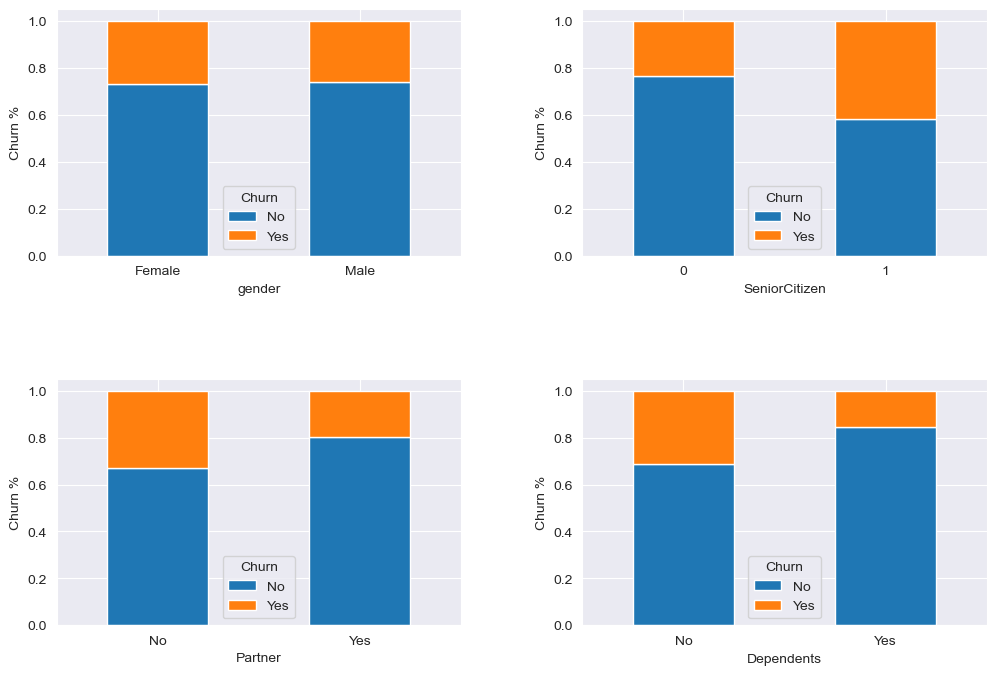

In [7]:
def get_plot(df, group, target, ax):
    temp_df = (df.groupby([group, target]).size()/df.groupby(group)[target].count()).reset_index().pivot(columns=target, index=group, values=0)
    temp_df.plot(kind='bar', stacked=True, ax=ax)
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(group)
    ax.set_ylabel('Churn %')


fig, axes = plt.subplots(2, 2, figsize=(12, 8))


get_plot(customer_data, "gender", "Churn", axes[0, 0])
get_plot(customer_data, "SeniorCitizen", "Churn", axes[0, 1])
get_plot(customer_data, "Partner", "Churn", axes[1, 0])
get_plot(customer_data, "Dependents", "Churn", axes[1, 1])

plt.subplots_adjust(wspace=0.3, hspace=0.5)


plt.show()


From above plots, we can say following:

Gender alone does not help us predict the customer churn.
If a person is young and has a family, he or she is less likely to stop the service as we can see below. The reason might be the busy life, more money or another factors.


### Tenure

In [8]:
customer_data['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [9]:
customer_data['tenure'].value_counts().head(10)

1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
70    119
Name: tenure, dtype: int64

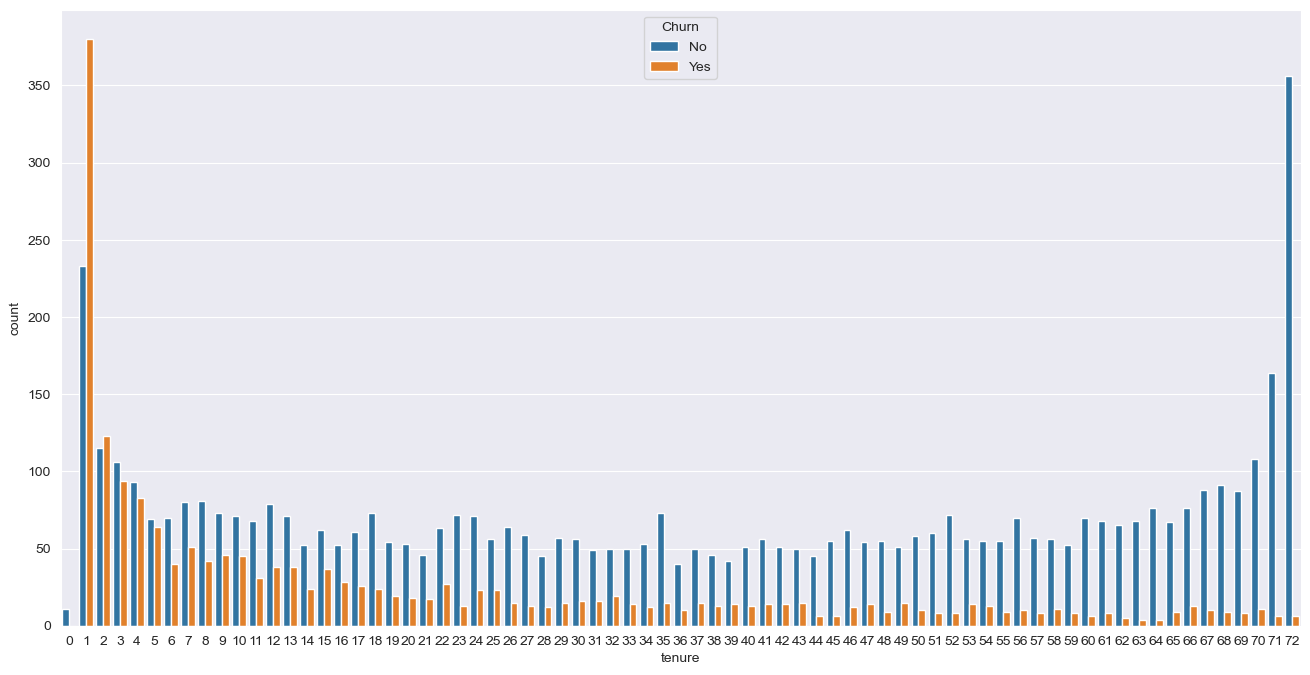

In [10]:
plt.figure(figsize=(16,8))
sns.countplot(x="tenure", hue="Churn", data=customer_data)
plt.show()

Converting into 5 groups to reduce model complexity.

In [11]:
def tenure(t):
    if t<=12:
        return 1
    elif t>12 and t<=24:
        return 2
    elif t>24 and t<=36:
        return 3
    elif t>36 and t<=48:
        return 4
    elif t>48 and t<=60:
        return 5
    else:
        return 6

customer_data["tenure_group"]=customer_data["tenure"].apply(lambda x: tenure(x))

In [12]:
customer_data["tenure_group"].value_counts()

1    2186
6    1407
2    1024
3     832
5     832
4     762
Name: tenure_group, dtype: int64

<Axes: xlabel='tenure_group', ylabel='count'>

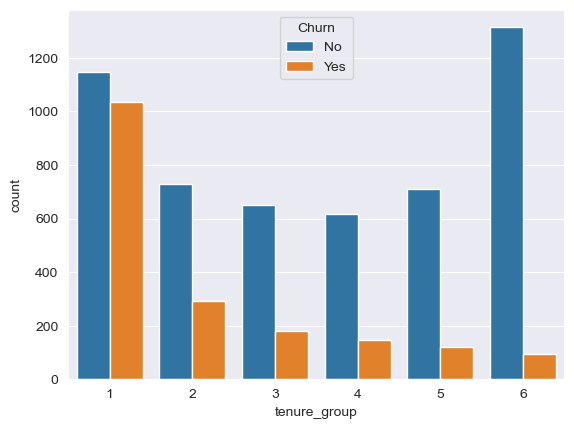

In [13]:
sns.countplot(x="tenure_group", hue="Churn", data=customer_data)

## OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies


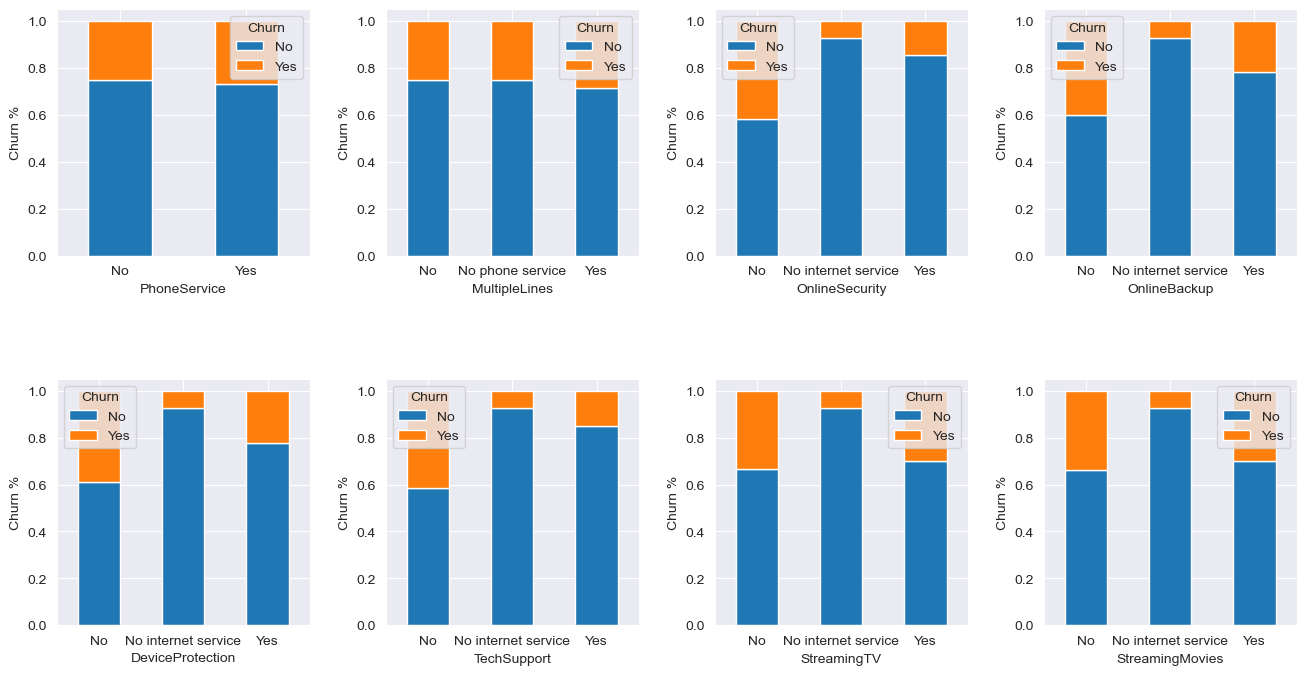

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

get_plot(customer_data, "PhoneService", "Churn", axes[0, 0])
get_plot(customer_data, "MultipleLines", "Churn", axes[0, 1])
get_plot(customer_data, "OnlineSecurity", "Churn", axes[0, 2])
get_plot(customer_data, "OnlineBackup", "Churn", axes[0, 3])
get_plot(customer_data, "DeviceProtection", "Churn", axes[1, 0])
get_plot(customer_data, "TechSupport", "Churn", axes[1, 1])
get_plot(customer_data, "StreamingTV", "Churn", axes[1, 2])
get_plot(customer_data, "StreamingMovies", "Churn", axes[1, 3])
plt.subplots_adjust(wspace=0.3, hspace=0.5)


plt.show()

As we can see multiplelines and phoneservice do not add value in the model having similar churn rate.

In all above categories we see consistent results. If a person does not opt for internet service, the customer churning is less. The reason might be the less cost of the service. Also, if they have internet service and does not opt for specific service their probability of churning is high.

# Customer Survival Analysis - Statistical Methods

## Non - Parametric Method 
Kaplan Meier and Log Rank Tests

In [15]:
!pip install lifelines

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as st
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

## Data Preparation 

In [17]:
customer_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,tenure_group
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No,3
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No,4
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No,2
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No,6
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No,1
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes,1


In [18]:
customer_data.Churn = labelencoder.fit_transform(customer_data.Churn)
customer_data.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [19]:
eventvar = customer_data['Churn']
timevar = customer_data['tenure']

For the analysis, I will need to create dummy variables for all categorical variables.

In [20]:
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']

survivaldata = pd.get_dummies(customer_data, columns = categorical, drop_first= True)
survivaldata.head()

,tenure,MonthlyCharges,Churn,tenure_group,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,0,3,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,0,4,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,2,70.70,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [21]:
survivaldata.drop(['tenure', 'Churn', 'tenure_group'], axis = 1, inplace= True)
survivaldata = st.add_constant(survivaldata, prepend=False)
survivaldata.head()

,MonthlyCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,const
0,29.85,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1.0
1,56.95,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1.0
2,53.85,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1.0
3,42.30,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
4,70.70,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1.0


## Kaplan Meier Curve

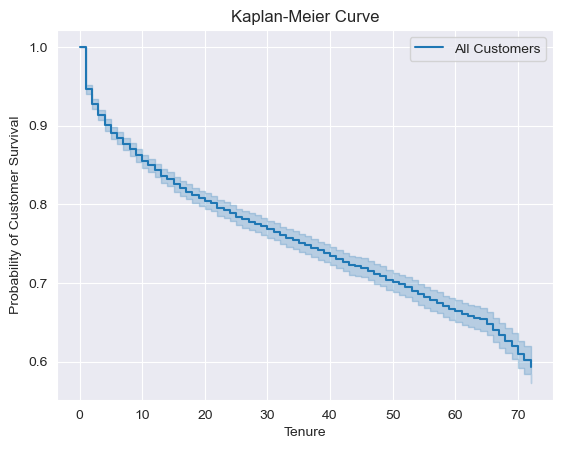

In [24]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All Customers")
#Plot the curve and assign labels
kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

As we can see, there is a sudden drop in the starting which says that after one tenure only customers starts churning rapidly and after that churning rate decreases. To deal with that we can consider giving more discounts on long-term plans and make more customers to subscribe for long term plans.

## Log Rank Test

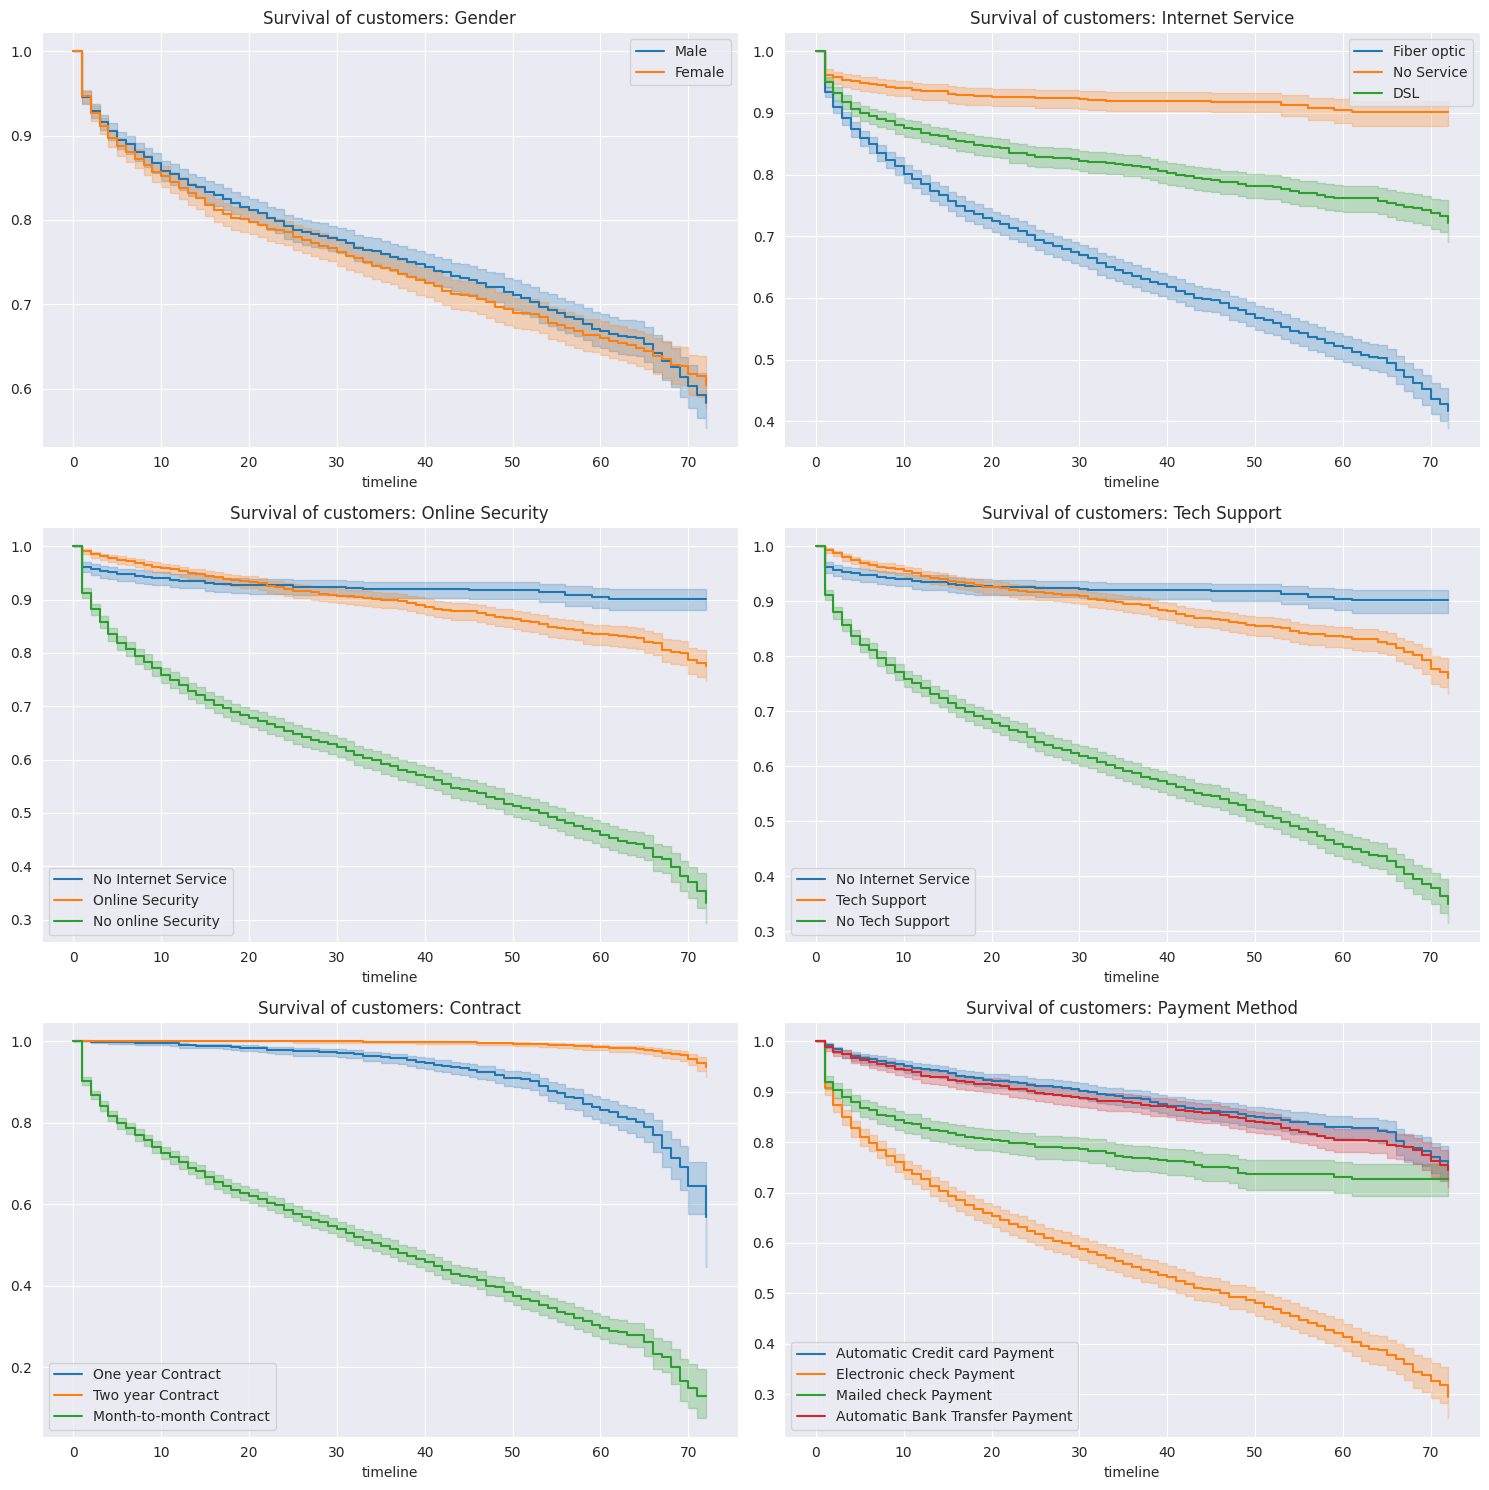

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Gender
male = (survivaldata['gender_Male'] == 1)
female = (survivaldata['gender_Male'] == 0)

kmf.fit(timevar[male], event_observed=eventvar[male], label="Male")
kmf.plot(ax=axes[0, 0])

kmf.fit(timevar[female], event_observed=eventvar[female], label="Female")
kmf.plot(ax=axes[0, 0])

axes[0, 0].set_title('Survival of customers: Gender')

# Internet Service
Fiber_optic = (survivaldata['InternetService_Fiber optic'] == 1)
No_Service = (survivaldata['InternetService_No'] == 1)
DSL = ((survivaldata['InternetService_Fiber optic'] == 0) & (survivaldata['InternetService_No'] == 0))

kmf.fit(timevar[Fiber_optic], event_observed=eventvar[Fiber_optic], label="Fiber optic")
kmf.plot(ax=axes[0, 1])

kmf.fit(timevar[No_Service], event_observed=eventvar[No_Service], label="No Service")
kmf.plot(ax=axes[0, 1])

kmf.fit(timevar[DSL], event_observed=eventvar[DSL], label="DSL")
kmf.plot(ax=axes[0, 1])

axes[0, 1].set_title('Survival of customers: Internet Service')

# Online Security
no_internetService = (survivaldata['OnlineSecurity_No internet service'] == 1)
onlineSecurity = (survivaldata['OnlineSecurity_Yes'] == 1)
no_onlineSecurity = ((survivaldata['OnlineSecurity_No internet service'] == 0) & (survivaldata['OnlineSecurity_Yes'] == 0))

kmf.fit(timevar[no_internetService], event_observed=eventvar[no_internetService], label="No Internet Service")
kmf.plot(ax=axes[1, 0])

kmf.fit(timevar[onlineSecurity], event_observed=eventvar[onlineSecurity], label="Online Security")
kmf.plot(ax=axes[1, 0])

kmf.fit(timevar[no_onlineSecurity], event_observed=eventvar[no_onlineSecurity], label="No online Security")
kmf.plot(ax=axes[1, 0])

axes[1, 0].set_title('Survival of customers: Online Security')

# Tech Support
no_internetService = (survivaldata['TechSupport_No internet service'] == 1)
TechSupport = (survivaldata['TechSupport_Yes'] == 1)
no_TechSupport = ((survivaldata['TechSupport_No internet service'] == 0) & (survivaldata['TechSupport_Yes'] == 0))

kmf.fit(timevar[no_internetService], event_observed=eventvar[no_internetService], label="No Internet Service")
kmf.plot(ax=axes[1, 1])

kmf.fit(timevar[TechSupport], event_observed=eventvar[TechSupport], label="Tech Support")
kmf.plot(ax=axes[1, 1])

kmf.fit(timevar[no_TechSupport], event_observed=eventvar[no_TechSupport], label="No Tech Support")
kmf.plot(ax=axes[1, 1])

axes[1, 1].set_title('Survival of customers: Tech Support')

# Contract
Contract_One_year = (survivaldata['Contract_One year'] == 1)
Contract_Two_year = (survivaldata['Contract_Two year'] == 1)
Contract_month_to_month = ((survivaldata['Contract_One year'] == 0) & (survivaldata['Contract_Two year'] == 0))

kmf.fit(timevar[Contract_One_year], event_observed=eventvar[Contract_One_year], label="One year Contract")
kmf.plot(ax=axes[2, 0])

kmf.fit(timevar[Contract_Two_year], event_observed=eventvar[Contract_Two_year], label="Two year Contract")
kmf.plot(ax=axes[2, 0])

kmf.fit(timevar[Contract_month_to_month], event_observed=eventvar[Contract_month_to_month], label="Month-to-month Contract")
kmf.plot(ax=axes[2, 0])

axes[2, 0].set_title('Survival of customers: Contract')

# Payment Method
automatic_Credit_Card = (survivaldata['PaymentMethod_Credit card (automatic)'] == 1)
electronic_check = (survivaldata['PaymentMethod_Electronic check'] == 1)
mailed_check = (survivaldata['PaymentMethod_Mailed check'] == 1)
automatic_Bank_Transfer = ((survivaldata['PaymentMethod_Credit card (automatic)'] == 0) & (survivaldata['PaymentMethod_Electronic check'] == 0) & (survivaldata['PaymentMethod_Mailed check'] == 0))

kmf.fit(timevar[automatic_Credit_Card], event_observed=eventvar[automatic_Credit_Card], label="Automatic Credit card Payment")
kmf.plot(ax=axes[2, 1])

kmf.fit(timevar[electronic_check], event_observed=eventvar[electronic_check], label="Electronic check Payment")
kmf.plot(ax=axes[2, 1])

kmf.fit(timevar[mailed_check], event_observed=eventvar[mailed_check], label="Mailed check Payment")
kmf.plot(ax=axes[2, 1])

kmf.fit(timevar[automatic_Bank_Transfer], event_observed=eventvar[automatic_Bank_Transfer], label="Automatic Bank Transfer Payment")
kmf.plot(ax=axes[2, 1])

axes[2, 1].set_title('Survival of customers: Payment Method')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Semi-Parametric Method 

Cox Regression, Penalized Cox Models (Lasso, Elastic Net)

In [32]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID","TotalCharges"], inplace = True, axis = 1)

    #df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    #df.TotalCharges.fillna(0, inplace = True)
    #df.TotalCharges = df.TotalCharges.astype(float)
  
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'Yes': 1, 'No internet service': 0, 'No': 0})

    categories = ['InternetService', 'Contract', 'PaymentMethod']
    
    df = pd.get_dummies(df, columns = categories, drop_first=True)
    
    return df

In [33]:
regression_df = datapreparation("customer_data.csv")
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   MultipleLines                          7043 non-null   int64  
 7   OnlineSecurity                         7043 non-null   int64  
 8   OnlineBackup                           7043 non-null   int64  
 9   DeviceProtection                       7043 non-null   int64  
 10  TechSupport                            7043 non-null   int64  
 11  Stre

In [34]:
cph = CoxPHFitter()
cph.fit(regression_df, duration_col='tenure', event_col='Churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13884.60
         time fit was run = 2023-04-23 01:56:22 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
gender                                  0.09       1.09       0.05            -0.01             0.18                 0.99                 1.19
SeniorCitizen                          -0.07       0.93       0.06            -0.18             0.04                 0.83                 1.04
Partner                                -0.52       0.60       0.06            -0.63            -0.41                 0.53                 0.66
Dependents                             -0.05       0.95       0.07            -0.19             0.08                 0.83                 1.08
PhoneService                            0.25       1.29       0.47            -0.67             1.18                 0.51                 3.25
MultipleLines                          -0.42       0.66       0.13            -0.67            -0.17                 0.51                 0.84
OnlineSecurity                         -0.61       0.54       0.13            -0.87            -0.35                 0.42                 0.70
OnlineBackup                           -0.61       0.54       0.13            -0.86            -0.36                 0.42                 0.69
DeviceProtection                       -0.28       0.75       0.13            -0.53            -0.04                 0.59                 0.96
TechSupport                            -0.37       0.69       0.13            -0.63            -0.11                 0.53                 0.90
StreamingTV                             0.04       1.04       0.24            -0.42             0.50                 0.66                 1.66
StreamingMovies                        -0.05       0.95       0.24            -0.52             0.41                 0.60                 1.50
PaperlessBilling                        0.18       1.20       0.06             0.07             0.29                 1.07                 1.34
MonthlyCharges                         -0.01       0.99       0.02            -0.05             0.04                 0.95                 1.04
InternetService_Fiber optic             0.59       1.80       0.58            -0.54             1.71                 0.58                 5.55
InternetService_No                     -1.30       0.27       0.59            -2.45            -0.15                 0.09                 0.86
Contract_One year                      -1.62       0.20       0.09            -1.79            -1.44                 0.17                 0.24
Contract_Two year                      -3.23       0.04       0.16            -3.56            -2.91                 0.03                 0.05
PaymentMethod_Credit card (automatic)  -0.08       0.92       0.09            -0.26             0.09                 0.77                 1.10
PaymentMethod_Electronic check          0.59       1.80       0.07             0.45             0.73                 1.56                 2.07
PaymentMethod_Mailed check              0.57       1.76       0.09             0.39             0.74                 1.48                 2.09

                                        cmp to      z      p   -log2(p)
covariate                                                              
gender                                    0.00   1.84   0.07       3.93
SeniorCitizen                             0.00  -1.26   0.21       2.27
Partner                                   0.00  -9.40 <0.

In [29]:
cph.concordance_index_

0.9285420942712247

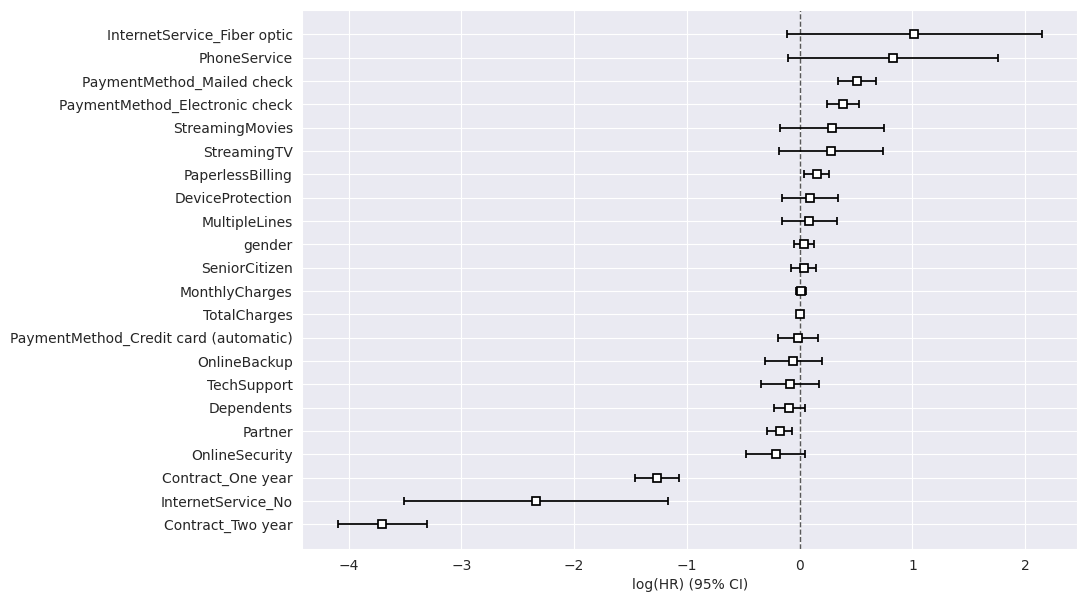

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax);

In [ ]:
test_id = regression_df.sample(1)

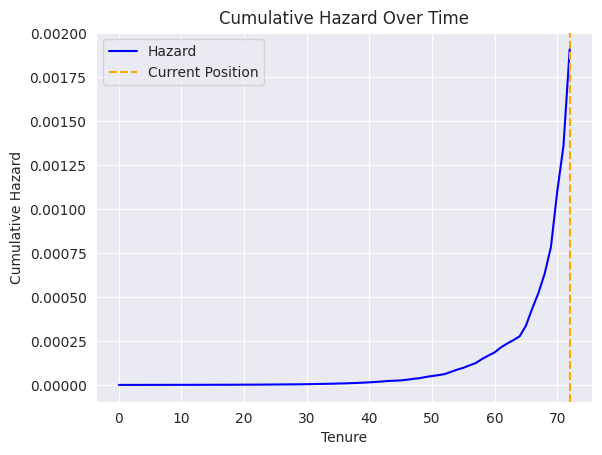

In [ ]:
fig, ax = plt.subplots()
cph.predict_cumulative_hazard(test_id).plot(ax = ax, color = 'blue')
plt.axvline(x=test_id.tenure.values[0], color = 'orange', linestyle='--')
plt.legend(labels=['Hazard','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Cumulative Hazard', size = 10)
ax.set_title('Cumulative Hazard Over Time');

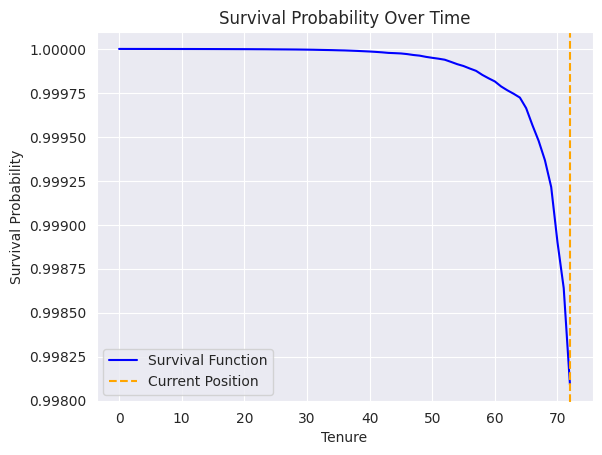

In [ ]:
fig, ax = plt.subplots()
cph.predict_survival_function(test_id).plot(ax = ax, color = 'blue')
plt.axvline(x=test_id.tenure.values[0], color = 'orange', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time');

In [ ]:

life = cph.predict_survival_function(test_id).reset_index()
life.columns = ['Tenure', 'Probability']
max_life = life.Tenure[life.Probability > 0.1].max()
    
LTV = max_life * test_id['MonthlyCharges'].values[0]


print('LTV of a testid is:', LTV, 'dollars.')

LTV of a testid is: 7239.599999999999 dollars.


<Axes: >

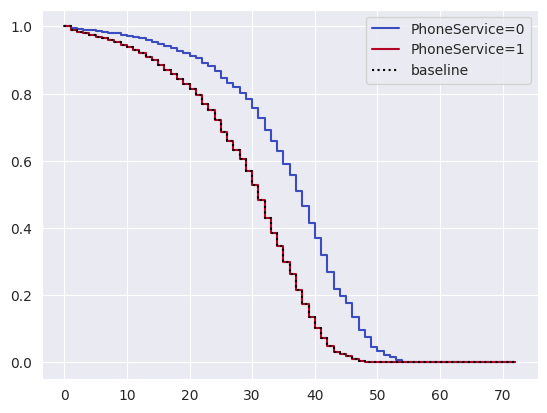

In [ ]:
cph.plot_partial_effects_on_outcome(covariates = 'PhoneService', values = [0,1], cmap = 'coolwarm')

In [ ]:
cph.check_assumptions(regression_df, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Contract_One year                     km            115.75 <0.005     87.26
                                      rank          102.16 <0.005     77.37
Contract_Two year                     km            152.13 <0.005    113.70
                                      rank          122.65 <0.005     92.28
Dependents                            km              0.19   0.66      0.59
                                      rank            0.19   0.66      0.60
DeviceProtection                      km              0.26   0.61      0.71
                                      rank            1.12   0.29      1.79
InternetService_Fiber optic           km              0.66   0.42      1.26
                                      rank            1.79   0.18      2.47
InternetService_No                    km              6.86   0.01      6.83
                                      rank           10.36 <0.005      9.60
MonthlyCharges                        km              0.33   0.57      0.82
                                      rank            0.08   0.78      0.35
MultipleLines                         km              0.58   0.45      1.17
                                      rank            2.44   0.12      3.08
OnlineBackup                          km              0.70   0.40      1.31
                                      rank            1.81   0.18      2.49
OnlineSecurity                        km              0.56   0.45      1.14
                                      rank            2.06   0.15      2.72
PaperlessBilling                      km              0.41   0.52      0.93
                                      rank            0.76   0.38      1.39
Partner                               km              2.66   0.10      3.28
                                      rank            4.72   0.03      5.07
PaymentMethod_Credit card (automatic) km              1.49   0.22      2.17
                                      rank            1.18   0.28      1.85
PaymentMethod_Electronic check        km              0.14   0.71      0.50
                                      rank            0.06   0.81      0.31
PaymentMethod_Mailed check            km              0.09   0.77      0.38
                                      rank            1.61   0.20      2.29
PhoneService                          km              0.83   0.36      1.47
                                      rank            2.26   0.13      2.92
SeniorCitizen                         km              3.62   0.06      4.13
                                      rank            2.03   0.15      2.70
StreamingMovies                       km              0.47   0.49      1.02
                                      rank            1.41   0.23      2.09
StreamingTV                           km              0.81   0.37      1.45
                                      rank            1.91   0.17      2.58
TechSupport                           km              1.18   0.28      1.85
                                      rank            2.93   0.09      3.53
TotalCharges                          km            154.94 <0.005    115.74
                                      rank           20.49 <0.005     17.35
gender                                km              0.00   0.98      0.03
                                      rank            0.16   0.69      0.54



1. Variable 'Partner' failed the non-proportional test: p-value is 0.0298.

   Advice: with so few unique values (only 2), you can include `strata=['Partner', ...]` in the call
in `.fit`. See documentation in link [E] below.

2. Variable 'TotalCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'TotalCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'TotalCharges' using pd.cut, and then specify it in
`strata=['TotalCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


3. Variable 'InternetService_No' failed the non-proportional test: p-value is 0.0013.

   Advice: with so few un

[]

In [ ]:
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, regression_df, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                                       test_statistic      p  -log2(p)
Contract_One year                              102.16 <0.005     77.37
Contract_Two year                              122.65 <0.005     92.28
Dependents                                       0.19   0.66      0.60
DeviceProtection                                 1.12   0.29      1.79
InternetService_Fiber optic                      1.79   0.18      2.47
InternetService_No                              10.36 <0.005      9.60
MonthlyCharges                                   0.08   0.78      0.35
MultipleLines                                    2.44   0.12      3.08
OnlineBackup                                     1.81   0.18      2.49
OnlineSecurity                                   2.06   0.15      2.72
PaperlessBilling                                 0.76   0.38      1.39
Partner                                          4.72   0.03      5.07
PaymentMethod_Credit card (automatic)            1.18   0.28      1.85
PaymentMethod_Electronic check                   0.06   0.81      0.31
PaymentMethod_Mailed check                       1.61   0.20      2.29
PhoneService                                     2.26   0.13      2.92
SeniorCitizen                                    2.03   0.15      2.70
StreamingMovies                                  1.41   0.23      2.09
StreamingTV                                      1.91   0.17      2.58
TechSupport                                      2.93   0.09      3.53
TotalCharges                                    20.49 <0.005     17.35
gender                                           0.16   0.69      0.54

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

feature_vif = calc_vif(regression_df.drop(['Churn', 'tenure'], axis=1))
feature_vif.sort_values('VIF')

,variables,VIF
1,SeniorCitizen,1.374461
17,Contract_One year,1.928742
3,Dependents,1.976077
0,gender,1.980659
19,PaymentMethod_Credit card (automatic),1.982661
21,PaymentMethod_Mailed check,2.301979
6,OnlineSecurity,2.550861
9,TechSupport,2.580563
7,OnlineBackup,2.766326
5,MultipleLines,2.788373


In [ ]:
features_keep = feature_vif.loc[feature_vif['VIF'] < 10, 'variables'].tolist()
features_keep.extend(['time', 'status'])
features_keep

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'TotalCharges',
 'InternetService_No',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'time',
 'status']

## Penalized Cox Model

In [ ]:
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text") 

In [ ]:
tenure = regression_df['tenure']
churn = regression_df['Churn']

In [ ]:
X = regression_df
X.drop(['tenure', 'Churn', 'MonthlyCharges', 'TotalCharges'], axis = 1, inplace= True)

In [ ]:
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

/usr/local/lib/python3.9/dist-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0


In [ ]:
structured_array = np.empty((len(churn),), dtype=[('churn', bool), ('tenure', float)])

structured_array['churn'] = churn.astype(bool)
structured_array['tenure'] = tenure.astype(float)

## RIDGE

In [ ]:
y = structured_array
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))


In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

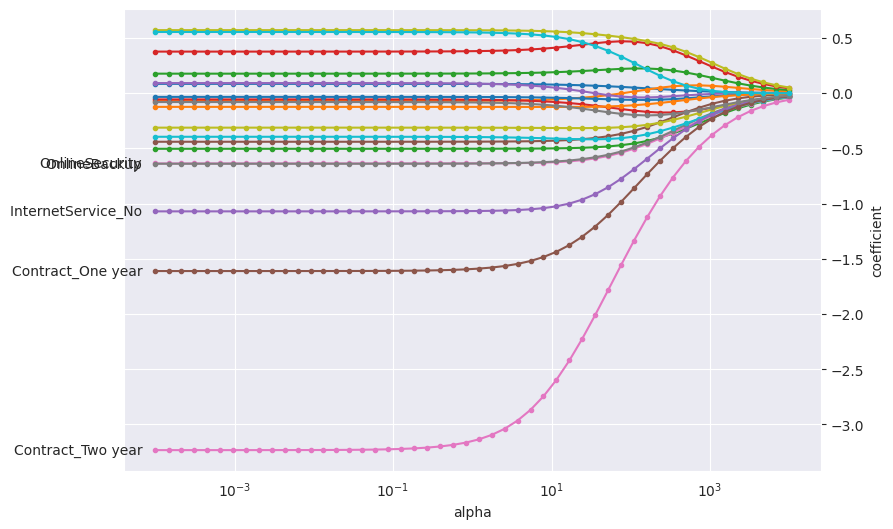

In [ ]:
plot_coefficients(coefficients, n_highlight=5)

## LASSO

In [ ]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

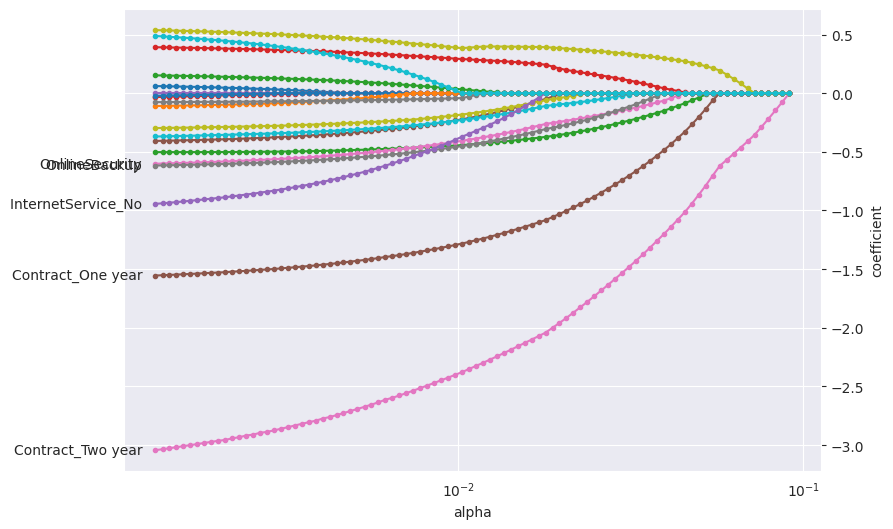

In [ ]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=Xt.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

## Choosing Alpha

In [ ]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

Number of non-zero coefficients: 20


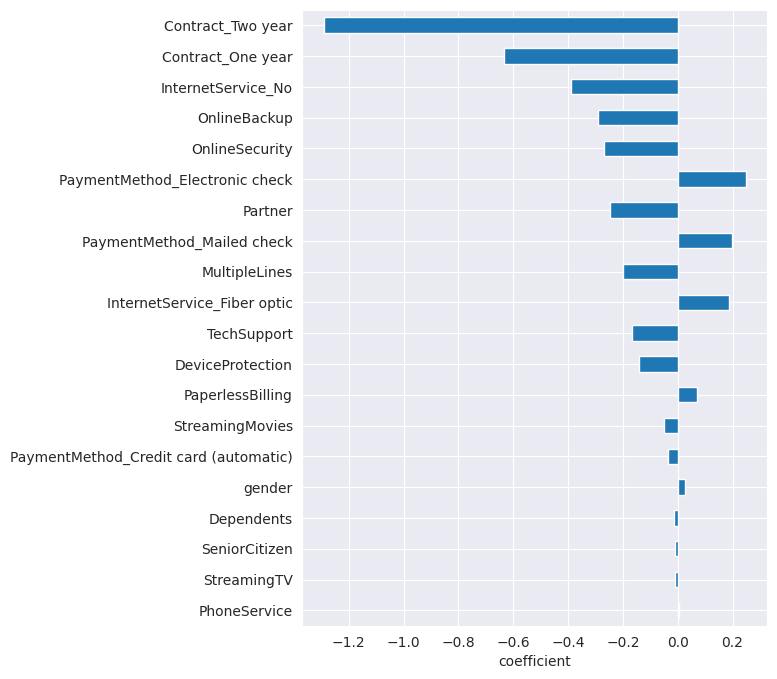

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

# AFT

In [36]:
import pandas as pd
import seaborn as sb
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [38]:
data = pd.read_csv("customer_data.csv")

In [39]:
## Churn = 'Yes' - the customer has cancelled subscription with the company
## Churn = 'No'  - the customer has been censored/lost track of the customer
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
data = data.drop(columns = ['TotalCharges','customerID'])

In [42]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID","TotalCharges"], inplace = True, axis = 1)

    #df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    #df.TotalCharges.fillna(0, inplace = True)
    #df.TotalCharges = df.TotalCharges.astype(float)
  
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'Yes': 1, 'No internet service': 0, 'No': 0})

    categories = ['InternetService', 'Contract', 'PaymentMethod']
    
    df = pd.get_dummies(df, columns = categories, drop_first=True)
    
    return df

In [47]:
data = datapreparation('customer_data.csv')

In [48]:
data.loc[data['tenure'] == 0, 'tenure'] = 1

In [83]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter

# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()

# Fit to data
for model in [wb, ex]:
    model.fit(durations = data["tenure"], event_observed = data["Churn"])
# Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 21157.25189215942
The AIC value for ExponentialFitter is 21697.15196629894


In [81]:
from lifelines import WeibullAFTFitter
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(data, duration_col='tenure', event_col='Churn')
weibull_aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8915.64
         time fit was run = 2023-04-23 02:43:25 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Contract_One year                       1.58       4.83       0.10             1.39             1.76                 4.00                 5.83
        Contract_Two year                       2.83      16.90       0.17             2.49             3.17                12.03                23.76
        Dependents                              0.10       1.11       0.07            -0.04             0.25                 0.96                 1.28
        DeviceProtection                        0.26       1.30       0.14            -0.00             0.53                 1.00                 1.70
        InternetService_Fiber optic            -0.71       0.49       0.62            -1.93             0.51                 0.15                 1.66
        InternetService_No                      1.50       4.47       0.63             0.26             2.74                 1.29                15.49
        MonthlyCharges                          0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
        MultipleLines                           0.42       1.53       0.14             0.16             0.69                 1.17                 1.99
        OnlineBackup                            0.57       1.77       0.14             0.31             0.84                 1.36                 2.32
        OnlineSecurity                          0.63       1.87       0.14             0.35             0.91                 1.41                 2.48
        PaperlessBilling                       -0.20       0.82       0.06            -0.32            -0.08                 0.72                 0.92
        Partner                                 0.51       1.66       0.06             0.39             0.62                 1.48                 1.86
        PaymentMethod_Credit card (automatic)   0.08       1.09       0.10            -0.11             0.27                 0.90                 1.32
        PaymentMethod_Electronic check         -0.63       0.53       0.08            -0.78            -0.48                 0.46                 0.62
        PaymentMethod_Mailed check             -0.63       0.53       0.09            -0.82            -0.45                 0.44                 0.64
        PhoneService                           -0.34       0.71       0.51            -1.34             0.66                 0.26                 1.94
        SeniorCitizen                           0.07       1.07       0.06            -0.05             0.19                 0.95                 1.21
        StreamingMovies                         0.01       1.01       0.25            -0.49             0.51                 0.61                 1.67
        StreamingTV                            -0.07       0.93       0.25            -0.57             0.43                 0.56                 1.53
        TechSupport                             0.41       1.51       0.14             0.13             0.69                 1.14                 2.00
        gender                                 -0.07       0.93       0.05            -0.17             0.02                 0.84                 1.03
        Intercept                               3.28      26.45       0.63             2.04             4.51                 7.70                90.78
rho_    Intercept                          

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

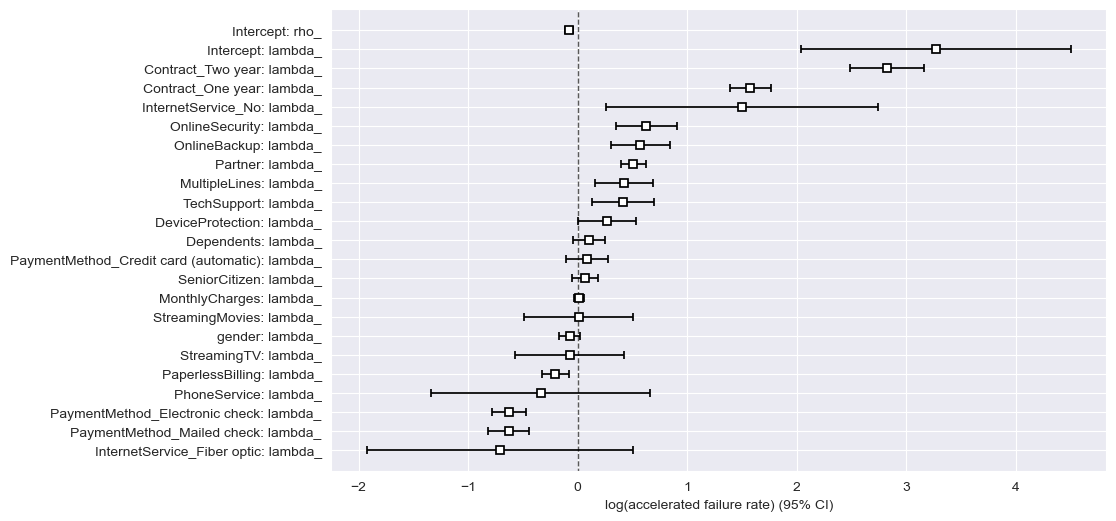

In [77]:
# Plotting coeffiecients
plt.subplots(figsize=(10, 6))
weibull_aft.plot()

In [75]:
# Median Survival Time (in months)
print(weibull_aft.median_survival_time_.round(2))
# Mean Survival Time (in months)
print(weibull_aft.mean_survival_time_.round(2))

24.21
37.39


# Random Survival Trees

In [ ]:
!pip install pycox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv

In [ ]:
df = pd.read_csv('customer_data.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df = df.drop(['customerID', 'TotalCharges'], axis=1)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes


In [ ]:
N = df.shape[0]
hasNotChurned = sum(df['Churn']=='No')
hasChurned = sum(df['Churn']=='Yes')

print(f'Number of samples: {N}')
print(f'Number of columns: {df.shape[1]}')
print(f'Number of customers that have churned: {hasChurned}')
print(f'Number of customers that have not churned yet: {hasNotChurned}')
print(f'Percentage of customers that have churned: {100*hasChurned/len(df):.0f}%')
print(f'Percentage of customers that have not churned yet: {100*hasNotChurned/len(df):.0f}%')

Number of samples: 7043
Number of columns: 19
Number of customers that have churned: 1869
Number of customers that have not churned yet: 5174
Percentage of customers that have churned: 27%
Percentage of customers that have not churned yet: 73%


In [ ]:
df['Churn'] = df['Churn'].map({'No': False, 'Yes': True})

# creating one-hot columns
categories = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
df = pd.get_dummies(df, columns=categories, drop_first=True, dtype=float)


In [ ]:
# creating the time and event columns
event_col = 'Churn'
time_col = 'tenure'

# extracting the features/covariables
features = np.setdiff1d(df.columns, [time_col, event_col]).tolist()
features

['Contract_One year',
 'Contract_Two year',
 'Dependents_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'MonthlyCharges',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'PaperlessBilling_Yes',
 'Partner_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'PhoneService_Yes',
 'SeniorCitizen',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'gender_Male']

In [ ]:
print(f'Number of features/covariables: {len(features)}')

Number of features/covariables: 28


# **Data Analysis**

We split the dataset into training (70%) and testing (30%) datasets.

In [ ]:
# Splitting data into training and validation sets
index_train, index_test = train_test_split(df.reset_index(), test_size = 0.3, random_state=0)
data_train = df.loc[index_train['index']].reset_index(drop=True)
data_test  = df.loc[index_test['index']].reset_index(drop=True)

# Creating the X, T and E inputs
X_trn, X_val = data_train[features], data_test[features]
T_trn, T_val = data_train[time_col], data_test[time_col]
E_trn, E_val = data_train[event_col], data_test[event_col]

In [ ]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=0)
X_trn1 = X_trn[E_trn == True]
T_trn1 = T_trn[E_trn == True]
E_trn1 = E_trn[E_trn == True]

In [ ]:
y_trn = np.rec.fromarrays([E_trn.astype(bool), T_trn], names=['event', 'time'])

In [ ]:
rsf.fit(X_trn, y_trn)

RandomSurvivalForest(random_state=0)

In [ ]:
y_val = np.rec.fromarrays([E_val.astype(bool), T_val], names=['event', 'time'])
c_index = rsf.score(X_val, y_val)
print("Concordance index on test set: {:.3f}".format(c_index))

Concordance index on test set: 0.845


In [ ]:
ci_rsf_trn = concordance_index(T_trn, -rsf.predict(X_trn), E_trn)
ci_rsf_val = concordance_index(T_val, -rsf.predict(X_val), E_val)

print(f'Concordance index of Random survival forest: train: {ci_rsf_trn:.3f}, valid: {ci_rsf_val:.3f}')

Concordance index of Random survival forest: train: 0.900, valid: 0.845


In [ ]:
from sklearn.inspection import permutation_importance

Text(0.5, 1.0, 'Feature Importance Scores - Random Survival Forest')

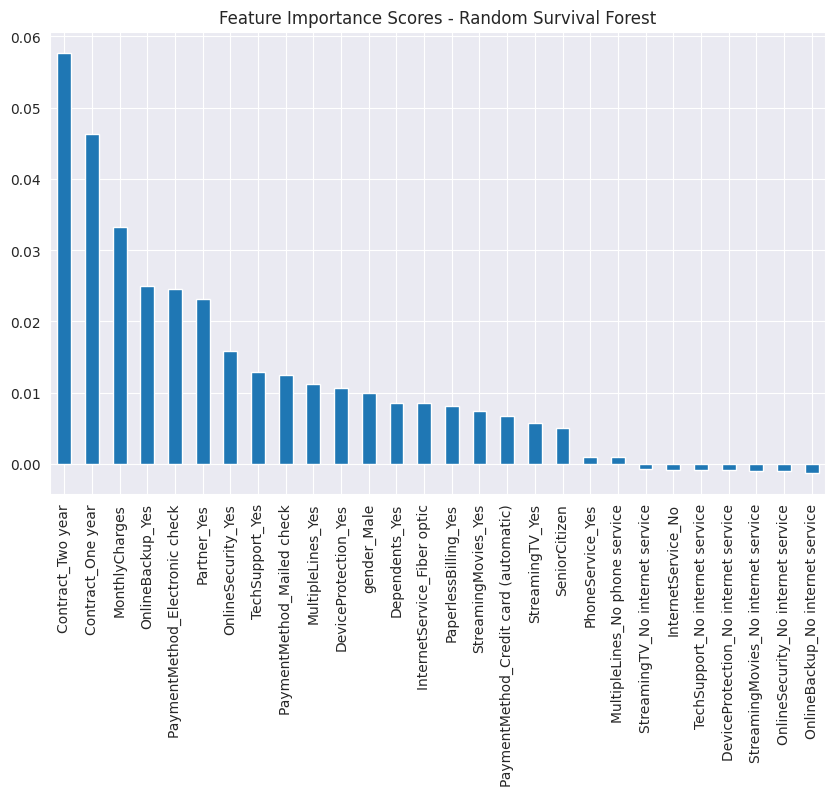

In [ ]:
result = permutation_importance(rsf, X_trn, y_trn, n_repeats=10, random_state=0)
feature_importances = pd.Series(result.importances_mean, index=X_trn.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature Importance Scores - Random Survival Forest")